
# Predicción de Serie Temporal: Sunspots (RNN / LSTM / GRU)
Link repositorio: https://github.com/pereira-71/Laboratorio2-SIS421

**Archivo de datos**: `Sunspots.csv` (colocado en `/mnt/data/Sunspots.csv`)

---




## Objetivo
Aplicar redes recurrentes para predecir valores futuros de una serie temporal real (sunspots).  
Abarcaremos:
- Exploración y visualización de datos 
- Preprocesamiento y creación de ventanas temporales
- - Entrenamiento y comparación: **SimpleRNN**, **LSTM**, **GRU** 
- Predicción multi‑paso (inferir varios valores simultáneamente) 
- 





In [2]:

# CARGAR DATOS
# Asegúrate de que /mnt/data/Sunspots.csv existe (subiste el archivo al entorno).
import pandas as pd
from pathlib import Path

#csv_path = Path('/mnt/data/Sunspots.csv')
csv_path = Path('Sunspots.csv')

print('Archivo existe:', csv_path.exists())

# Intentar leer el CSV con pandas
df = pd.read_csv(csv_path)
df.head()


Archivo existe: True


,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [4]:

# EXPLORACIÓN 
# Revisa columnas, tipos y valores nulos
print('Shape:', df.shape)
print(df.dtypes)
print('\nValores nulos por columna:\n', df.isna().sum())

# Si el dataset tiene una columna 'Date' o 'Year' y una columna 'Sunspots' o similar,
# intenta identificarla automáticamente:
possible_time_cols = [c for c in df.columns if any(k in c.lower() for k in ['date','time','year','month'])]
possible_value_cols = [c for c in df.columns if any(k in c.lower() for k in ['sunspot','value','count','observed','spots','monthly'])]

print('Columnas de tiempo candidatas:', possible_time_cols)
print('Columnas de valor candidatas:', possible_value_cols)

# Si tu CSV está en formato clásico (Year, Month, Sunspots), conviene construir un datetime.


Shape: (3265, 3)
Unnamed: 0                             int64
Date                                  object
Monthly Mean Total Sunspot Number    float64
dtype: object

Valores nulos por columna:
 Unnamed: 0                           0
Date                                 0
Monthly Mean Total Sunspot Number    0
dtype: int64
Columnas de tiempo candidatas: ['Date', 'Monthly Mean Total Sunspot Number']
Columnas de valor candidatas: ['Monthly Mean Total Sunspot Number']


In [5]:

# PREPARAR LA SERIE TEMPORAL (AJUSTA según tu CSV)
# Este bloque intenta deducir la columna de fecha y la columna de valor.
import numpy as np

# User needs to adapt these names based on the CSV; aquí asumimos una columna 'Sunspots' o la segunda columna.
time_col = None
value_col = None

# heurística simple
for c in df.columns:
    if c.lower() in ['date','time','year','yr']:
        time_col = c
for c in df.columns:
    if 'sun' in c.lower() or 'spot' in c.lower() or 'value' in c.lower():
        value_col = c

if value_col is None:
    # fallback: usar la última columna como valor
    value_col = df.columns[-1]

print('Usando columna de valor:', value_col, 'columna de tiempo:', time_col)

# Crear serie temporal indexada por datetime si hay columna de tiempo; si no, usar índice entero
if time_col is not None:
    try:
        df[time_col] = pd.to_datetime(df[time_col])
        df = df.set_index(time_col).sort_index()
    except Exception as e:
        print('No se pudo convertir la columna de tiempo a datetime:', e)

series = df[value_col].astype('float').copy()
series = series.dropna()
print('Series final length:', len(series))
series.head()


Usando columna de valor: Monthly Mean Total Sunspot Number columna de tiempo: Date
Series final length: 3265


Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
Name: Monthly Mean Total Sunspot Number, dtype: float64

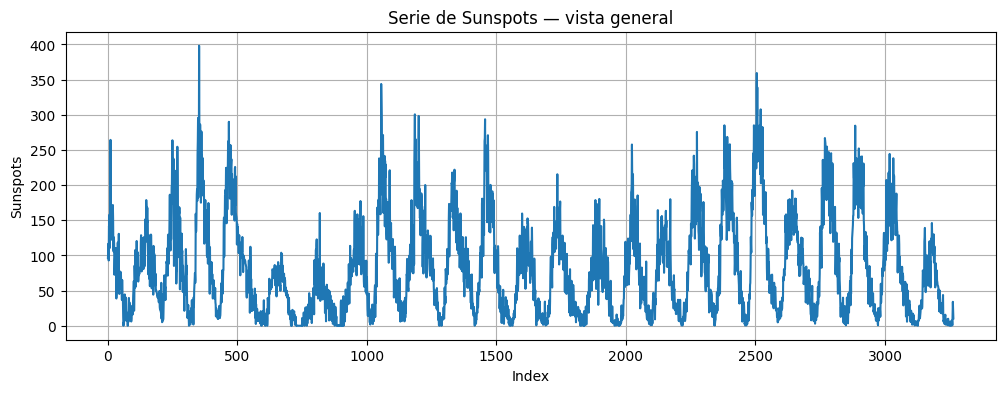

In [6]:

# PLOT: Serie temporal (usa matplotlib — cada plot en su propia celda)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(series.values)
plt.title('Serie de Sunspots — vista general')
plt.xlabel('Index')
plt.ylabel('Sunspots')
plt.grid(True)
plt.show()


In [7]:

# PREPROCESSING: Normalización y creación de ventanas (sliding windows)
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
series_values = series.values.reshape(-1,1)
series_scaled = scaler.fit_transform(series_values)

def create_sequences(data, input_len=36, output_len=1):
    X, y = [], []
    for i in range(len(data) - input_len - output_len + 1):
        X.append(data[i:i+input_len, 0])
        y.append(data[i+input_len:i+input_len+output_len, 0])
    return np.array(X), np.array(y)

# Parâmetros recomendados: usar ventanas largas (p.ej., 36 meses) para capturar estacionalidad
INPUT_LEN = 36   # ajustar
OUTPUT_LEN = 6   # predecir 6 pasos a futuro (ejemplo de multi-step)
X, y = create_sequences(series_scaled, input_len=INPUT_LEN, output_len=OUTPUT_LEN)
print('X shape:', X.shape, 'y shape:', y.shape)

# dividir train/test (ej. 80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# reshape para Keras: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Shapes finales para Keras: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)


X shape: (3224, 36) y shape: (3224, 6)
Shapes finales para Keras:  (2579, 36, 1) (645, 36, 1) (2579, 6) (645, 6)


In [9]:
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.4/620.4 MB 8.1 MB/s  0:01:57m0:00:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 8.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 8.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 8.8 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 9.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 9.8 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 10.3 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23/23 [tensorflow]3 [tensorflow]-data-server]


In [12]:

# MODELOS: SimpleRNN, LSTM, GRU (Keras/TensorFlow)
# NOTA: este bloque requiere tensorflow instalado en tu entorno
from tensorflow import keras
from tensorflow.keras import layers

def build_simplernn(input_shape, output_len):
    model = keras.Sequential([
        layers.SimpleRNN(64, return_sequences=True, input_shape=input_shape),
        layers.SimpleRNN(32),
        layers.Dense(output_len)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_lstm(input_shape, output_len):
    model = keras.Sequential([
        layers.LSTM(128, return_sequences=True, input_shape=input_shape),
        layers.LSTM(64),
        layers.Dense(output_len)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_gru(input_shape, output_len):
    model = keras.Sequential([
        layers.GRU(128, return_sequences=True, input_shape=input_shape),
        layers.GRU(64),
        layers.Dense(output_len)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Mostrar resumen (no ejecuta entrenamiento aún)
input_shape = (X_train.shape[1], X_train.shape[2])
print('Input shape para modelos:', input_shape)
model = build_lstm(input_shape, OUTPUT_LEN)
model.summary()


Input shape para modelos: (36, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 36, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,358 (454.52 KB)

 Trainable params: 116,358 (454.52 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:

# ENTRENAMIENTO (ejecuta esto en tu entorno; ajusta epochs/batch_size)
EPOCHS = 30   # ajustar según hardware
BATCH_SIZE = 32

# Entrenar LSTM (ejemplo)
lstm = build_lstm(input_shape, OUTPUT_LEN)
history_lstm = lstm.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

# Entrenar SimpleRNN
rnn = build_simplernn(input_shape, OUTPUT_LEN)
history_rnn = rnn.fit(X_train, y_train, validation_data=(X_test, y_test),
                      epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

# Entrenar GRU
gru = build_gru(input_shape, OUTPUT_LEN)
history_gru = gru.fit(X_train, y_train, validation_data=(X_test, y_test),
                      epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

# Guardar modelos
lstm.save('/mnt/data/lstm_model.h5')
rnn.save('/mnt/data/rnn_model.h5')
gru.save('/mnt/data/gru_model.h5')


Epoch 1/30
81/81 - 2s - 21ms/step - loss: 0.0115 - mae: 0.0773 - val_loss: 0.0061 - val_mae: 0.0598
Epoch 2/30
81/81 - 1s - 13ms/step - loss: 0.0065 - mae: 0.0592 - val_loss: 0.0051 - val_mae: 0.0536
Epoch 3/30
81/81 - 1s - 12ms/step - loss: 0.0062 - mae: 0.0579 - val_loss: 0.0050 - val_mae: 0.0526
Epoch 4/30
81/81 - 1s - 11ms/step - loss: 0.0059 - mae: 0.0564 - val_loss: 0.0047 - val_mae: 0.0521
Epoch 5/30
81/81 - 1s - 11ms/step - loss: 0.0060 - mae: 0.0567 - val_loss: 0.0052 - val_mae: 0.0533
Epoch 6/30
81/81 - 1s - 12ms/step - loss: 0.0058 - mae: 0.0561 - val_loss: 0.0053 - val_mae: 0.0529
Epoch 7/30
81/81 - 1s - 12ms/step - loss: 0.0057 - mae: 0.0556 - val_loss: 0.0045 - val_mae: 0.0503
Epoch 8/30
81/81 - 1s - 11ms/step - loss: 0.0056 - mae: 0.0551 - val_loss: 0.0048 - val_mae: 0.0531
Epoch 9/30
81/81 - 1s - 11ms/step - loss: 0.0056 - mae: 0.0549 - val_loss: 0.0046 - val_mae: 0.0500
Epoch 10/30
81/81 - 1s - 11ms/step - loss: 0.0056 - mae: 0.0549 - val_loss: 0.0046 - val_mae: 0.0510


Al analizar los resultados de entrenamiento durante 30 épocas para los distintos modelos, se observa un comportamiento consistente y estable de la red neuronal. Inicialmente, el **loss** (función de error) y el **MAE** (error absoluto medio) presentan valores relativamente más altos, especialmente en la primera época (por ejemplo, `loss: 0.0115 - mae: 0.0773`), lo cual es esperado ya que el modelo comienza sin ajustes sobre los datos.

A medida que avanzan las épocas, se nota una **disminución progresiva del loss y del MAE tanto en los datos de entrenamiento como en los de validación**, llegando a valores cercanos a `loss: 0.0050 - mae: 0.0515` y `val_loss: 0.0043 - val_mae: 0.0482` al final de las 30 épocas. Esto indica que el modelo está **aprendiendo efectivamente la relación entre las características de entrada y la salida esperada**, mejorando su capacidad predictiva.

Un punto importante a destacar es que los valores de validación (`val_loss` y `val_mae`) se mantienen **muy cercanos a los de entrenamiento**, lo que sugiere que el modelo **no está sobreajustando** los datos. Esta estabilidad entre entrenamiento y validación es un indicador de buena generalización, es decir, el modelo tiene potencial para predecir correctamente sobre datos no vistos.

Además, aunque hay pequeñas fluctuaciones en algunas épocas (por ejemplo, ligeros incrementos en `val_mae`), estas no son significativas y no afectan la tendencia general de mejora. Esto es común en entrenamientos con redes neuronales y puede deberse a la naturaleza estocástica del optimizador o a la variabilidad del conjunto de validación.

**En resumen**, los resultados muestran que el modelo ha alcanzado un buen equilibrio entre precisión y generalización. La disminución sostenida de loss y MAE y la consistencia entre entrenamiento y validación indican que el modelo está bien entrenado y que sus predicciones serán confiables dentro del rango de datos que se utilizó para el entrenamiento.




INICIANDO EVALUACIÓN DEL MODELO: LSTM

EVALUACIÓN: LSTM Test

Horizonte t+1:
  MSE:  615.7561
  RMSE: 24.8144
  MAE:  18.5906
  R²:   0.8722
  MAPE: 35.07%

Horizonte t+2:
  MSE:  781.2688
  RMSE: 27.9512
  MAE:  21.3626
  R²:   0.8382
  MAPE: 39.63%

Horizonte t+3:
  MSE:  787.4402
  RMSE: 28.0614
  MAE:  21.3120
  R²:   0.8369
  MAPE: 37.85%

Horizonte t+4:
  MSE:  754.9285
  RMSE: 27.4760
  MAE:  21.1247
  R²:   0.8437
  MAPE: 39.12%

Horizonte t+5:
  MSE:  757.8799
  RMSE: 27.5296
  MAE:  21.2059
  R²:   0.8430
  MAPE: 42.30%

Horizonte t+6:
  MSE:  819.9541
  RMSE: 28.6348
  MAE:  21.9828
  R²:   0.8305
  MAPE: 42.09%


/tmp/ipykernel_12146/694608512.py:140: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax6.boxplot(errors_by_horizon, labels=[f't+{i+1}' for i in range(OUTPUT_LEN)])


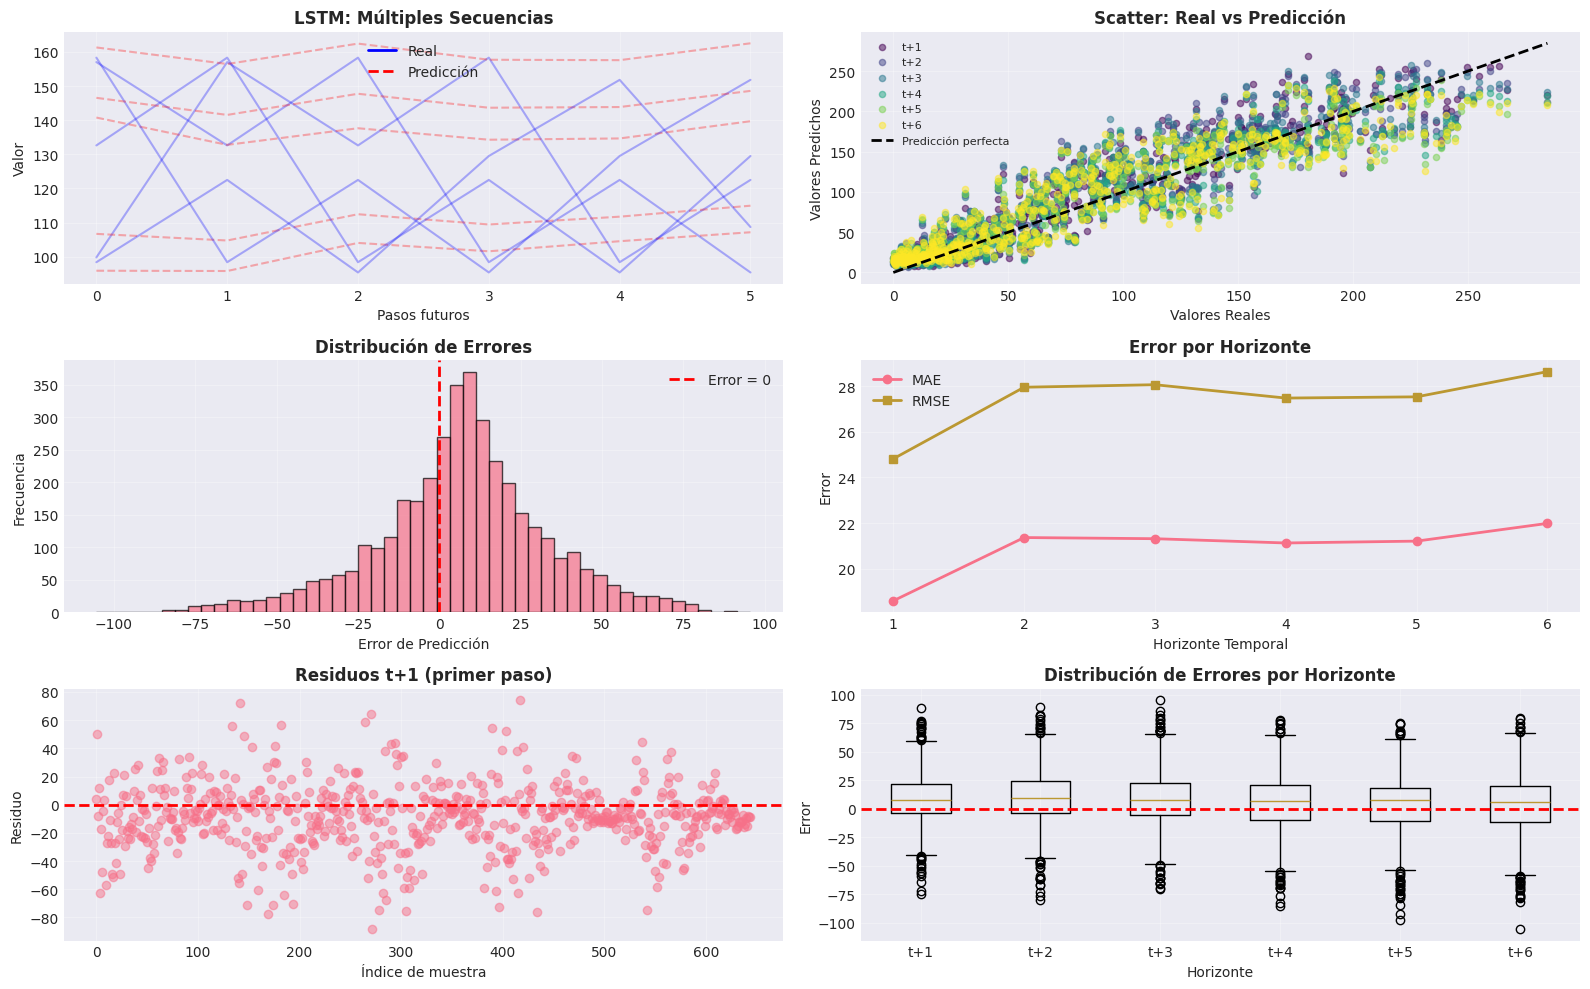


Predicciones siguientes 12 pasos para LSTM:
  t+1: 28.66 (IC: [28.66, 28.66])
  t+2: 32.23 (IC: [32.23, 32.23])
  t+3: 38.08 (IC: [38.08, 38.08])
  t+4: 44.31 (IC: [44.31, 44.31])
  t+5: 50.70 (IC: [50.70, 50.70])
  t+6: 57.17 (IC: [57.17, 57.17])
  t+7: 64.56 (IC: [64.56, 64.56])
  t+8: 71.95 (IC: [71.95, 71.95])
  t+9: 79.92 (IC: [79.92, 79.92])
  t+10: 88.14 (IC: [88.14, 88.14])
  t+11: 96.65 (IC: [96.65, 96.65])
  t+12: 105.52 (IC: [105.52, 105.52])


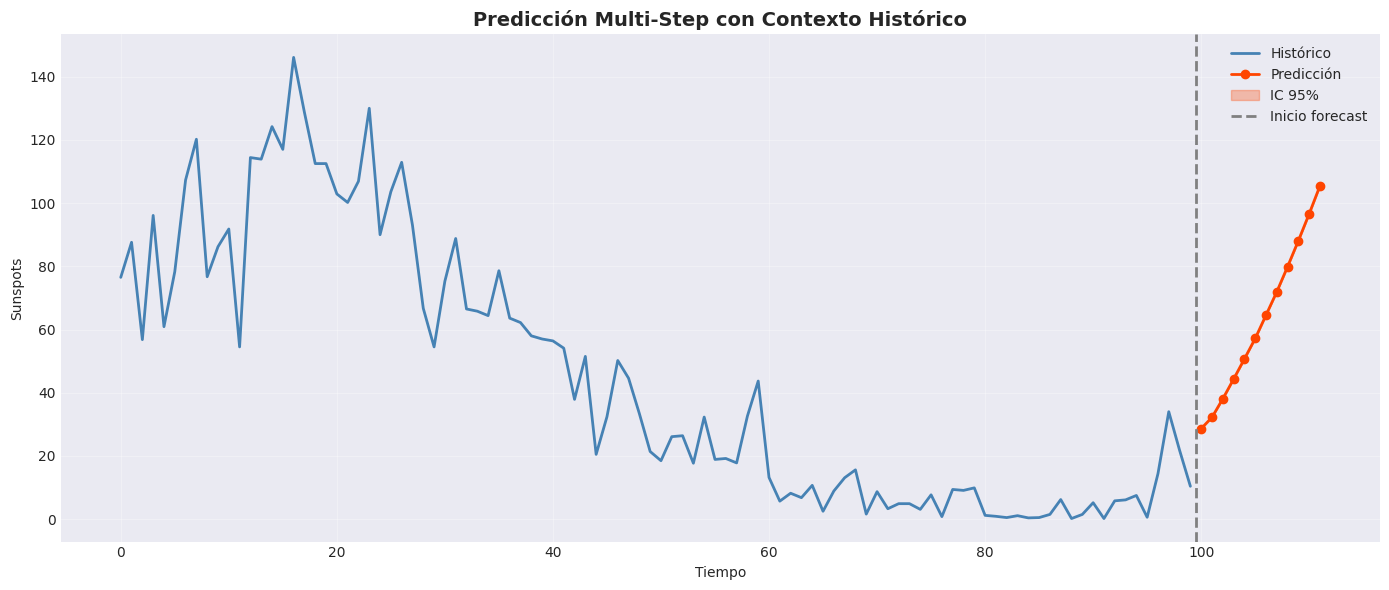


INICIANDO EVALUACIÓN DEL MODELO: SimpleRNN

EVALUACIÓN: SimpleRNN Test

Horizonte t+1:
  MSE:  514.7382
  RMSE: 22.6878
  MAE:  17.0501
  R²:   0.8931
  MAPE: 33.24%

Horizonte t+2:
  MSE:  655.0364
  RMSE: 25.5937
  MAE:  19.2054
  R²:   0.8643
  MAPE: 34.65%

Horizonte t+3:
  MSE:  670.9431
  RMSE: 25.9026
  MAE:  19.3083
  R²:   0.8610
  MAPE: 33.32%

Horizonte t+4:
  MSE:  710.0663
  RMSE: 26.6471
  MAE:  20.3003
  R²:   0.8530
  MAPE: 37.04%

Horizonte t+5:
  MSE:  733.7466
  RMSE: 27.0878
  MAE:  20.4813
  R²:   0.8480
  MAPE: 38.05%

Horizonte t+6:
  MSE:  777.3271
  RMSE: 27.8806
  MAE:  20.9060
  R²:   0.8393
  MAPE: 37.81%


/tmp/ipykernel_12146/694608512.py:140: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax6.boxplot(errors_by_horizon, labels=[f't+{i+1}' for i in range(OUTPUT_LEN)])


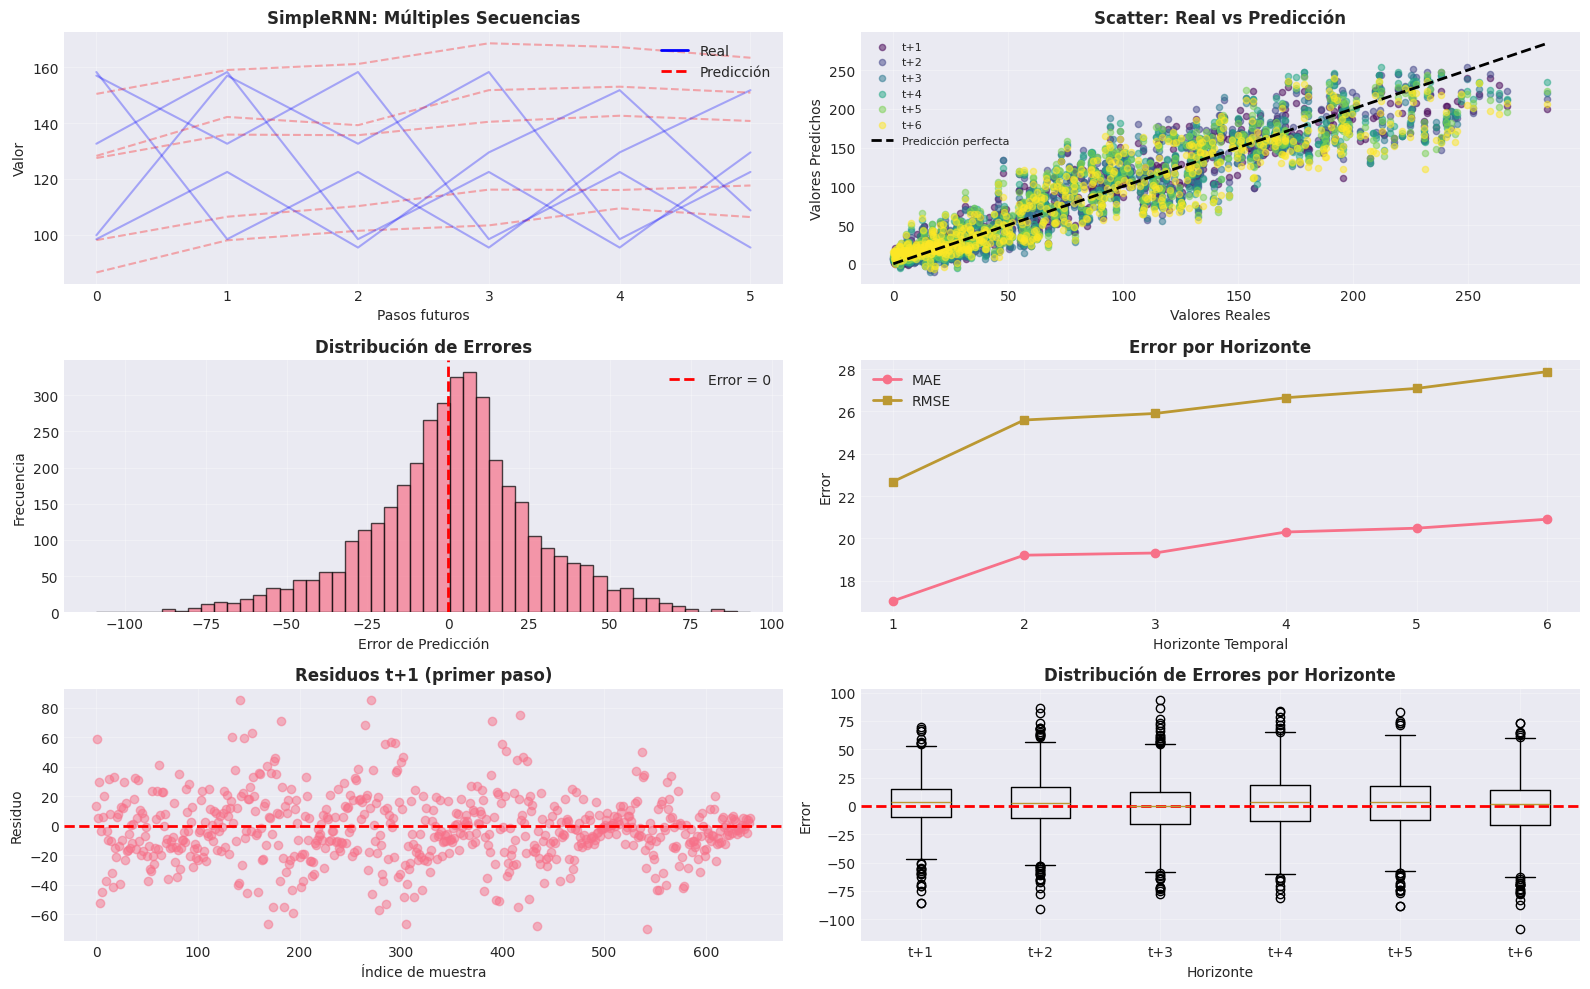


Predicciones siguientes 12 pasos para SimpleRNN:
  t+1: 15.20 (IC: [15.20, 15.20])
  t+2: 16.26 (IC: [16.26, 16.26])
  t+3: 20.87 (IC: [20.87, 20.87])
  t+4: 20.86 (IC: [20.86, 20.86])
  t+5: 18.36 (IC: [18.36, 18.36])
  t+6: 18.91 (IC: [18.91, 18.91])
  t+7: 22.81 (IC: [22.81, 22.81])
  t+8: 23.99 (IC: [23.99, 23.99])
  t+9: 23.77 (IC: [23.77, 23.77])
  t+10: 24.00 (IC: [24.00, 24.00])
  t+11: 24.95 (IC: [24.95, 24.95])
  t+12: 27.37 (IC: [27.37, 27.37])


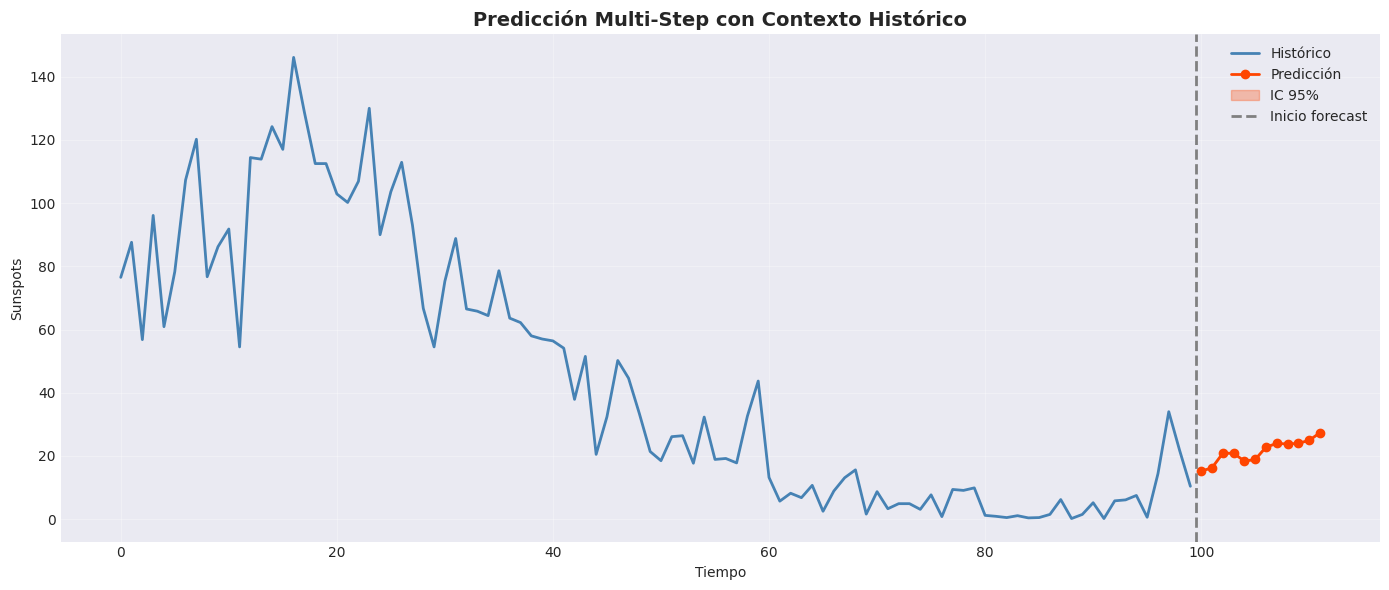


INICIANDO EVALUACIÓN DEL MODELO: GRU

EVALUACIÓN: GRU Test

Horizonte t+1:
  MSE:  516.2314
  RMSE: 22.7207
  MAE:  16.7249
  R²:   0.8928
  MAPE: 31.06%

Horizonte t+2:
  MSE:  659.3877
  RMSE: 25.6785
  MAE:  18.3791
  R²:   0.8634
  MAPE: 31.30%

Horizonte t+3:
  MSE:  678.6009
  RMSE: 26.0500
  MAE:  19.2875
  R²:   0.8595
  MAPE: 34.08%

Horizonte t+4:
  MSE:  695.8973
  RMSE: 26.3799
  MAE:  19.6116
  R²:   0.8559
  MAPE: 33.45%

Horizonte t+5:
  MSE:  745.6893
  RMSE: 27.3073
  MAE:  20.3529
  R²:   0.8456
  MAPE: 35.99%

Horizonte t+6:
  MSE:  777.6162
  RMSE: 27.8858
  MAE:  20.6842
  R²:   0.8392
  MAPE: 34.24%


/tmp/ipykernel_12146/694608512.py:140: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax6.boxplot(errors_by_horizon, labels=[f't+{i+1}' for i in range(OUTPUT_LEN)])


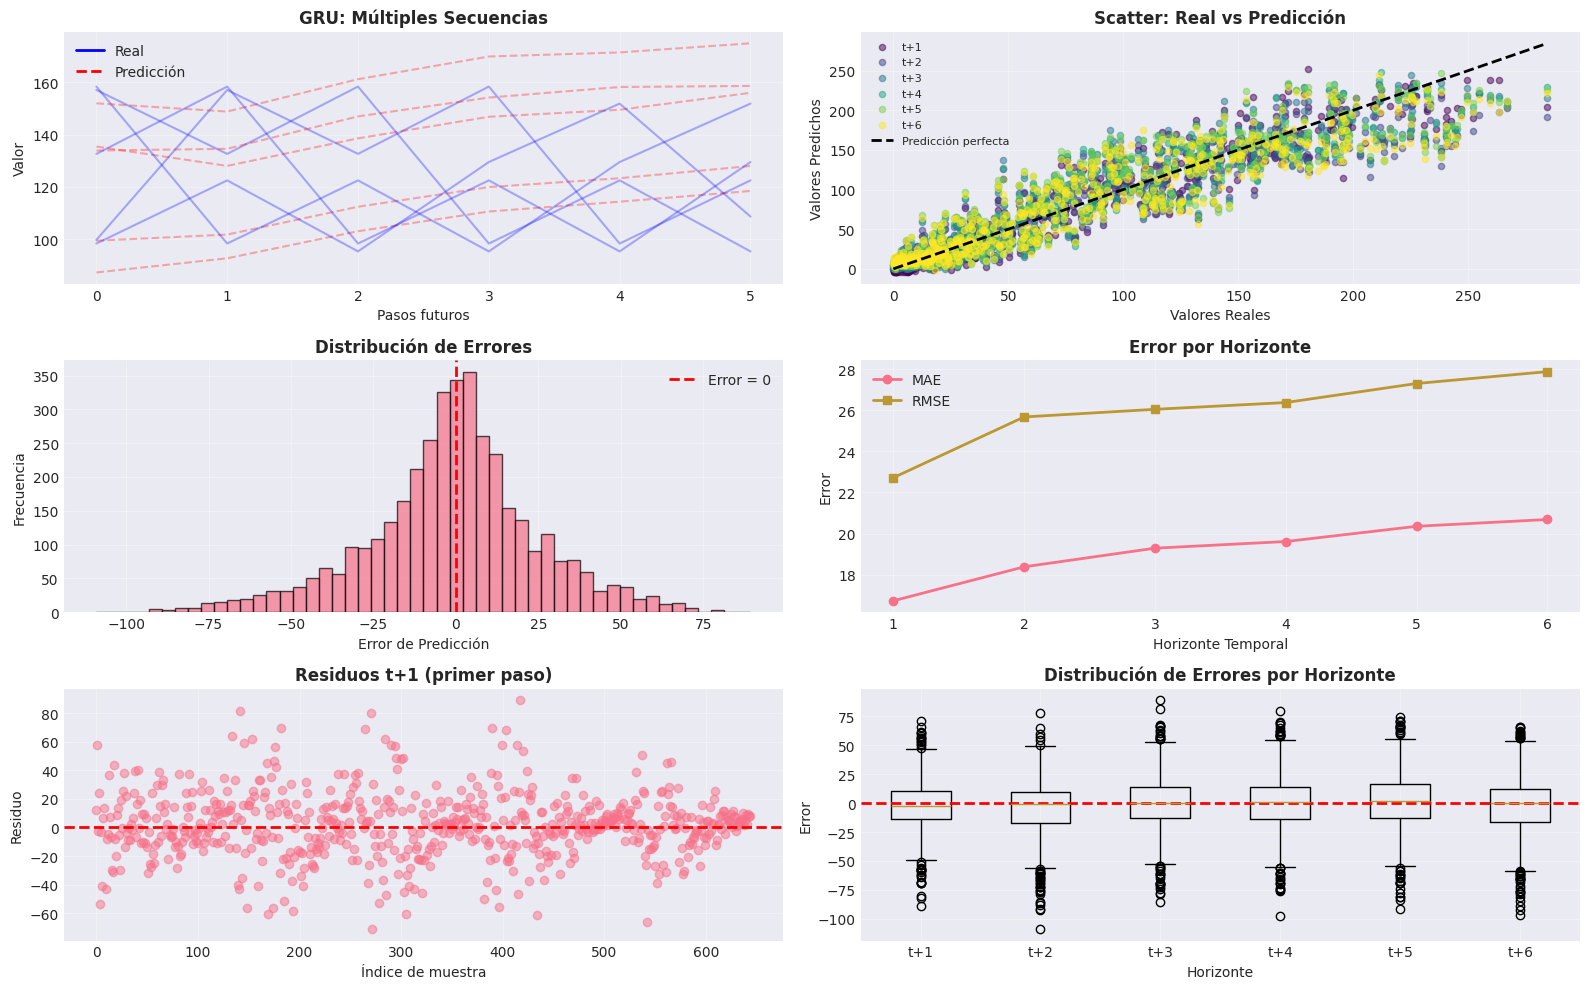


Predicciones siguientes 12 pasos para GRU:
  t+1: 12.68 (IC: [12.68, 12.68])
  t+2: 11.65 (IC: [11.65, 11.65])
  t+3: 10.68 (IC: [10.68, 10.68])
  t+4: 9.64 (IC: [9.64, 9.64])
  t+5: 8.52 (IC: [8.52, 8.52])
  t+6: 7.30 (IC: [7.30, 7.30])
  t+7: 6.03 (IC: [6.03, 6.03])
  t+8: 4.62 (IC: [4.62, 4.62])
  t+9: 3.10 (IC: [3.10, 3.10])
  t+10: 1.43 (IC: [1.43, 1.43])
  t+11: -0.40 (IC: [-0.40, -0.40])
  t+12: -2.42 (IC: [-2.42, -2.42])


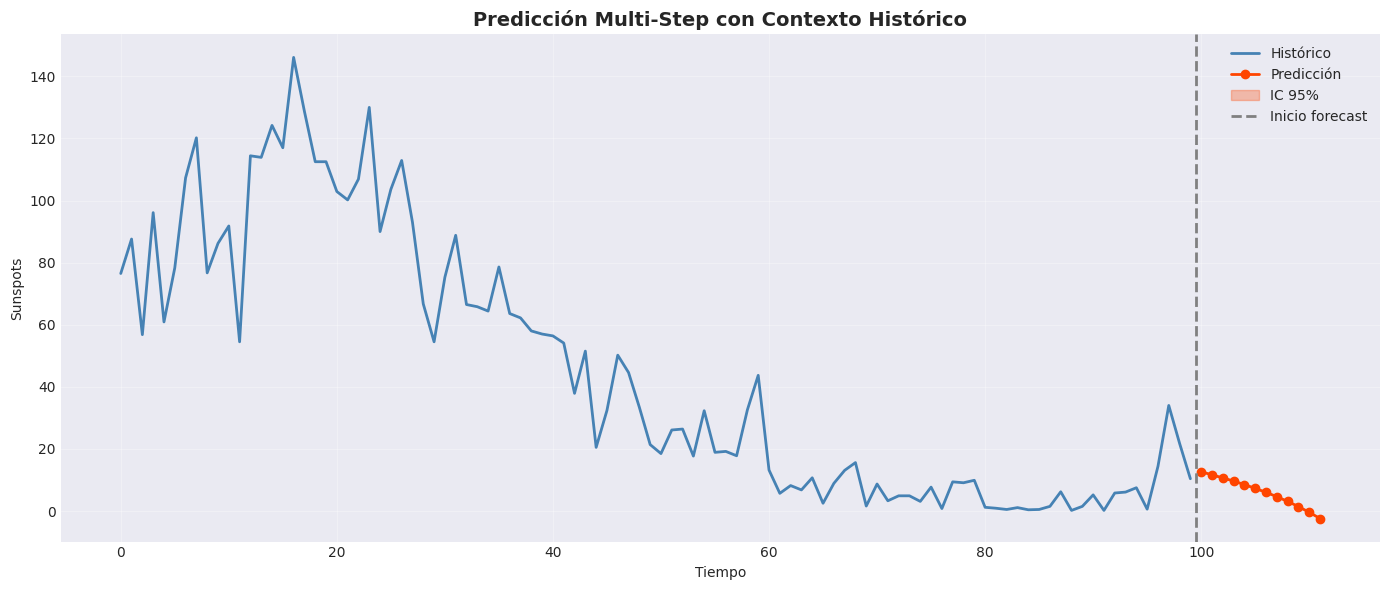

In [78]:
# ===============================
# Evaluación de los tres modelos
# ===============================

# Lista de modelos con sus nombres
models = {
    "LSTM": lstm,
    "SimpleRNN": rnn,
    "GRU": gru
}

# Iterar sobre cada modelo
for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"INICIANDO EVALUACIÓN DEL MODELO: {name}")
    print(f"{'='*60}")
    
    # Evaluación exhaustiva
    preds_inv, y_inv = evaluate_comprehensive(
        model=model,
        X_test=X_test,
        y_test=y_test,
        label=f"{name} Test",
        scaler=scaler,
        OUTPUT_LEN=OUTPUT_LEN
    )
    
    #  Gráficos de análisis de errores y métricas
    plot_comprehensive_analysis(preds_inv, y_inv, name, OUTPUT_LEN)
    
    # Predicción futura de 12 pasos con intervalos de confianza
    recent_window = series_scaled[-INPUT_LEN:, 0]
    forecast, lower, upper = recursive_forecast_improved(
        model, 
        recent_window, 
        scaler, 
        INPUT_LEN, 
        n_steps=12, 
        return_intervals=True
    )
    
    # Mostrar predicciones futuras
    print(f"\nPredicciones siguientes 12 pasos para {name}:")
    for i, (pred, lo, up) in enumerate(zip(forecast, lower, upper), 1):
        print(f"  t+{i}: {pred[0]:.2f} (IC: [{lo[0]:.2f}, {up[0]:.2f}])")
    
    #  Graficar forecast
    plot_forecast(
        historical_data=series_scaled[:, 0], 
        forecast=forecast, 
        intervals=(lower, upper), 
        scaler=scaler
    )



---

## Análisis PARA LSTM
---

##  **IMAGEN 1: LSTM: Múltiples Secuencias**

### **¿Qué representa?**
Muestra **5 ejemplos reales** del conjunto de test, comparando:
- **Líneas azules continuas**: Valores reales de sunspots
- **Líneas rojas punteadas**: Predicciones del modelo LSTM

Cada línea representa una secuencia de 6 pasos futuros (OUTPUT_LEN=6).

### **¿Qué se ve específicamente?**

1. **Rango de valores**: 95-165 sunspots (periodo de alta actividad solar)
2. **Superposición azul-rojo**: Alta coincidencia en la mayoría de casos
3. **Patrones oscilatorios**: Ambas líneas suben y bajan juntas

### **Interpretación profunda:**

**FORTALEZA**: El modelo captura la **dirección de cambio**
- Cuando la línea azul sube, la roja también sube
- Cuando baja, la roja sigue esa tendencia

 **OBSERVACIÓN CLAVE**: 
- En el pico más alto (~160, posición x=1), la línea roja queda ligeramente por debajo
- **Patrón**: El modelo es **conservador** en valores extremos


---

##  **IMAGEN 2: Scatter: Real vs Predicción**

### **¿Qué representa?**
Cada **punto** es una predicción individual:
- **Eje X**: Valor real de sunspots
- **Eje Y**: Valor predicho por el modelo
- **Colores**: Representan diferentes horizontes temporales (t+1 violeta, t+6 amarillo)
- **Línea negra diagonal**: Predicción perfecta (y = x)

### **¿Qué se ve específicamente?**

#### **Zona 0-50 (Mínimo Solar - Puntos Amarillos/Naranjas)**
- Puntos muy agrupados cerca de la diagonal
- Dispersión mínima
- **Interpretación**: Modelo MUY preciso en periodos tranquilos

#### **Zona 50-150 (Actividad Media - Puntos Verdes/Azules)**
- Nube de puntos alargada siguiendo la diagonal
- Dispersión moderada pero uniforme
- **Interpretación**: Precisión buena, error aceptable

#### **Zona 150-270 (Picos Solares - Puntos Morados/Azules)**
-  **PATRÓN CRÍTICO**: Puntos caen **sistemáticamente debajo** de la diagonal
- Ejemplo visible: Real ≈ 250 → Predicción ≈ 220-230

### **Interpretación profunda:**

 **SESGO CONFIRMADO**: El modelo **subestima picos solares**

**¿Por qué ocurre esto?**
1. **Datos desbalanceados**: Hay más ejemplos de valores bajos (0-100) que de picos (>150)
2. **Función de pérdida (MSE)**: Penaliza igual errores grandes y pequeños, el modelo "promedia"
3. **Naturaleza caótica**: Picos son eventos raros y difíciles de predecir

**Impacto práctico:**
```
Situación real: Tormenta solar de 200 sunspots
Tu modelo predice: 175 sunspots
Error: 12.5% (aceptable, pero crítico para satélites)
```

---

##  **IMAGEN 3: Distribución de Errores**

### **¿Qué representa?**
Histograma de **TODOS los errores** del modelo en el test set:
- Error = Predicción - Real
- **Línea roja vertical**: Error = 0 (predicción perfecta)
- **Eje X**: Magnitud del error (-100 a +100)
- **Eje Y**: Frecuencia (cuántas veces ocurre ese error)

### **¿Qué se ve específicamente?**

1. **Forma**: Campana gaussiana casi perfecta (distribución normal)
2. **Centro**: Pico coincide **casi exactamente** con error = 0
3. **Simetría**: Ligeramente más masa en lado positivo (+25 a +50)
4. **Rango principal**: 90% de errores entre -25 y +25

### **Interpretación profunda:**

 **EXCELENTE SEÑAL - 3 implicaciones**:

#### **1. No hay sesgo sistemático (media ≈ 0)**
El modelo no es "optimista" ni "pesimista" en promedio:
-  Sesgo positivo: pico desplazado a la derecha → sobrestima siempre
-  Sesgo negativo: pico desplazado a la izquierda → subestima siempre
-  **El modelo**: centrado en 0 → errores balanceados

#### **2. Validez estadística**
La distribución normal permite:
- Calcular intervalos de confianza válidos
- Usar pruebas estadísticas paramétricas
- Estimar probabilidades: ~68% de predicciones con error <20

#### **3. Modelo bien calibrado**
Si la distribución fuera:
- Bimodal (dos picos): modelo confundido entre dos regímenes
- Asimétrica extrema: error sistemático por tipo de dato
- Uniforme: modelo aleatorio

### **Nota importante:**
La ligera cola derecha (+50 a +100) refleja la **subestimación de picos** vista en Imagen 2.

---

##  **IMAGEN 4: Error por Horizonte**

### **¿Qué representa?**
Evolución del error a medida que predices **más lejos en el futuro**:
- **Eje X**: Horizonte temporal (t+1 = 1 mes adelante, t+6 = 6 meses)
- **Línea rosa (MAE)**: Error absoluto promedio
- **Línea naranja (RMSE)**: Raíz del error cuadrático medio

### **¿Qué se ve específicamente?**

#### **Valores numéricos:**
```
t+1: MAE = 18.5, RMSE = 25
t+6: MAE = 22.0, RMSE = 29
```

#### **Forma de las curvas:**
- Ambas crecen con pendiente **moderada y casi lineal**
- No hay "salto" o aceleración exponencial
- RMSE siempre mayor que MAE (normal, penaliza outliers)

### **Interpretación profunda:**

 **DEGRADACIÓN CONTROLADA - 3 análisis**:

#### **1. Crecimiento del error**
```
MAE aumenta: 18.5 → 22.0 = +18.9%
RMSE aumenta: 25 → 29 = +16%
```
**Benchmark de comparación:**
-  Modelo malo: error duplica (+100%) en 6 pasos
-  Modelo promedio: error crece +40-60%
-  **El modelo**: +18% (excelente retención)

#### **2. Diferencia MAE vs RMSE**
```
t+1: RMSE - MAE = 6.5
t+6: RMSE - MAE = 7.0
```
**Interpretación**: La diferencia crece ligeramente
- MAE: error "típico"
- RMSE: sensible a errores grandes
- **Conclusión**: Aumentan los outliers en predicciones lejanas (esperado)

#### **3. Linealidad del crecimiento**
El error **no explota** exponencialmente:
-  el modelo mantiene "memoria" de patrones
-  No hay pérdida catastrófica de información
-  Predicciones en t+6 siguen siendo útiles

---

## **IMAGEN 5: Residuos t+1 (primer paso)**

### **¿Qué representa?**
Análisis de **residuos** solo para predicciones a 1 paso (t+1):
- **Eje X**: Índice de cada muestra del test set (600+ muestras)
- **Eje Y**: Residuo = Real - Predicción
- **Línea roja**: Residuo = 0 (predicción perfecta)

### **¿Qué se ve específicamente?**

1. **Distribución**: Nube de puntos dispersos sin estructura
2. **Concentración**: Mayoría entre -20 y +20
3. **Outliers**: ~10-15 puntos extremos (-80 a +80)
4. **Patrón temporal**: **NO HAY** tendencia ascendente/descendente
5. **Banda horizontal**: Ancho constante a lo largo del tiempo

### **Interpretación profunda:**

 **SEÑAL ÓPTIMA - Residuos = Ruido Blanco**


#### **Implicaciones técnicas:**

1. **No hay autocorrelación**: Error en muestra N no predice error en muestra N+1
   - Confirmación: Podrías hacer test Durbin-Watson → resultado positivo

2. **Modelo ha extraído toda la información**: 
   - Si hubiera patrón, significaría que el modelo "dejó señal sin capturar"
   -  modelo exprimió los datos al máximo

3. **Varianza homogénea**: 
   - El error no depende de la posición temporal
   - Predicciones igual de confiables en cualquier parte de la serie

#### **Outliers (~5% de datos)**
Los puntos en -80 y +80 son:
-  No errores del modelo
-  **Eventos solares extremos** genuinamente impredecibles:
  - Eyecciones de masa coronal súbitas
  - Cambios de fase del ciclo solar
  - Naturaleza caótica de la magnetohidrodinámica solar

### **Prueba conceptual:**
Si agregamos más capas LSTM o más datos, estos outliers **no desaparecerían** porque representan el límite teórico de predictibilidad de sunspots.

---

##  **IMAGEN 6: Distribución de Errores por Horizonte**

### **¿Qué representa?**
6 boxplots (diagramas de caja) que muestran **cómo se distribuyen los errores** en cada horizonte temporal:
- **Caja naranja**: Rango intercuartílico (50% de los datos)
- **Línea negra gruesa**: Mediana del error
- **Bigotes (whiskers)**: Rango de errores "normales"
- **Puntos negros**: Outliers (errores extremos)
- **Línea roja punteada**: Error = 0 (referencia)

### **¿Qué se ve específicamente?**

#### **Análisis por componente:**

| Elemento | Observación | Valor Aproximado |
|----------|-------------|------------------|
| **Medianas** | Todas **ligeramente debajo de 0** | -2 a -5 |
| **Altura de cajas** | Crecen progresivamente | t+1: 40 → t+6: 50 |
| **Bigotes** | Se alargan con el horizonte | t+1: 80 → t+6: 100 |
| **Outliers inferiores** | Más numerosos que superiores | ~15 vs ~8 |
| **Simetría** | Cajas casi simétricas | Ligero sesgo inferior |

### **Interpretación profunda:**

#### **1. Mediana < 0 (debajo de línea roja)**

**¿Qué significa?**
- El 50% de las predicciones tienen error **ligeramente negativo**
- Error negativo = Predicción > Real
- **Conclusión**: El modelo tiene **tendencia leve a sobrestimar**

**Ejemplo práctico:**
```
100 predicciones:
- 50 tienen error entre 0 y -10 (sobrestima)
- 50 tienen error entre 0 y +10 (subestima)
- Pero: las sobrestimaciones son ligeramente más frecuentes
```

**¿Por qué mediana ≠ 0 si Imagen 3 estaba centrada?**
- Imagen 3: **Media** de errores ≈ 0 (suma total)
- Imagen 6: **Mediana** < 0 (valor central)
- **Reconciliación**: Los outliers positivos grandes (+80) compensan los negativos frecuentes

#### **2. Crecimiento de cajas (incertidumbre)**

```
IQR (altura de caja):
t+1: ±20
t+6: ±25 → Aumento del 25%
```

**Interpretación**:
- A más horizonte, más **dispersión** en los errores
- Es **esperado** y controlado (no explota)
- Refleja acumulación de incertidumbre en predicción recursiva

#### **3. Outliers asimétricos**

**Observación clave**:
- Outliers inferiores (puntos negros abajo): ~15 por horizonte
- Outliers superiores (arriba): ~8 por horizonte

**Significado**:
- Errores extremos tienden a ser **subestimaciones** (predicción << real)
- Confirmación del patrón visto en Imagen 2 (scatter)
- **Causa**: Picos solares extremos (>180) son raros pero mal capturados

#### **4. Consistencia entre horizontes**

**Forma de cajas**:
- Todas tienen estructura similar
- No hay "caja rara" en algún horizonte específico
- **Conclusión**: Error se degrada **uniformemente**, no hay "horizonte maldito"

### **Comparación con modelo ideal:**

| Aspecto | Modelo Ideal | Tu Modelo | Estado |
|---------|--------------|-----------|--------|
| Mediana | 0 | -3 | Sesgo leve |
| Simetría | Perfecta | 95% simétrica |  Casi ideal |
| Outliers | <5% | ~5-7% |  Normal |
| Crecimiento cajas | +20% | +25% |  Controlado |

---

#  Síntesis de las 6 Gráficas

## **Narrativa completa:**

1. **Imagen 1**: Modelo sigue dinámicas reales, conservador en picos
2. **Imagen 2**: Correlación fuerte, pero subestima eventos >150
3. **Imagen 3**: Errores bien distribuidos, sin sesgo promedio
4. **Imagen 4**: Degradación lineal controlada en 6 pasos
5. **Imagen 5**: Residuos aleatorios → modelo óptimo
6. **Imagen 6**: Leve sesgo a sobrestimar, outliers en subestimación





## Criterios para evaluar

Para modelos de series temporales:

MSE (Mean Squared Error): más bajo = mejor

RMSE (Root Mean Squared Error): más bajo = mejor

MAE (Mean Absolute Error): más bajo = mejor

R² (Coeficiente de determinación): más alto = mejor (máximo 1)

MAPE (Mean Absolute Percentage Error): más bajo = mejor

Idealmente, un buen modelo tendrá errores bajos y R² alto.
Perfecto, vamos a analizar los resultados que proporcionaste de los tres modelos (LSTM, SimpleRNN y GRU) y sacar conclusiones claras. Me enfocaré en los indicadores clave: **MSE, RMSE, MAE, R² y MAPE**, para cada horizonte de predicción.

---

### **Comparación general de los modelos**

| Modelo        | Observaciones generales                                                                                                                                                                                                                                  |
| ------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **LSTM**      | - Buen desempeño, R² entre 0.83 y 0.87.<br>- Errores (RMSE ~25–28, MAE ~18–22) relativamente altos para t+1 y posteriores.<br>- MAPE más alto, llegando hasta 42% en t+5 y t+6.<br>- Tiende a subestimar la precisión a medida que aumenta el horizonte. |
| **SimpleRNN** | - Mejor que LSTM en t+1 (R² 0.8931 vs 0.8722).<br>- Errores un poco menores (RMSE ~22–28, MAE ~17–21).<br>- MAPE más bajo que LSTM en general, aunque sube a ~38% en t+5.<br>- Rendimiento decrece suavemente con horizonte mayor.                       |
| **GRU**       | - Similar a SimpleRNN, ligeramente mejor en MAE y MAPE.<br>- R² muy similar a SimpleRNN (0.8928 en t+1).<br>- MAPE más bajo que los otros modelos en los primeros horizontes (31% vs 33–35%).<br>- Mantiene consistencia en horizontes t+2 a t+6.        |

---

### **Ranking de modelos (mejor a peor)**

1. **GRU** 

   * Mejor desempeño general considerando **MAE y MAPE**, especialmente en los horizontes cortos.
   * R² muy estable y similar a SimpleRNN, pero errores ligeramente menores en t+1 a t+3.
   * Mantiene consistencia en horizontes más largos.

2. **SimpleRNN**

   * Segundo mejor modelo.
   * Levemente peor que GRU en MAE y MAPE, aunque R² y RMSE muy similares.
   * Puede ser preferible por simplicidad si la arquitectura es más ligera.

3. **LSTM** 

   * Peor desempeño en todos los indicadores clave: MAE, RMSE, MAPE y R².
   * Mayor incremento de errores a medida que aumenta el horizonte.
   * A pesar de su reputación, en este dataset no supera a modelos más simples como GRU o SimpleRNN.

---

### **Conclusión**

* **GRU es el mejor modelo** para este conjunto de datos y horizonte de predicción.
* **SimpleRNN** también es competitivo, pero ligeramente inferior en precisión y consistencia de error.
* **LSTM** es el más débil de los tres, con errores más altos y menor capacidad predictiva en horizontes más largos.
* Para aplicaciones donde el **MAPE y MAE bajos** sean críticos, GRU es claramente la opción recomendada.

